In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from typing import Union
import pandas as pd
import numpy as np

In [2]:
ModelRegressor = Union[RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, LogisticRegression]

In [30]:
def dummy_fit_predict(classifier: ModelRegressor, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame) -> tuple():
    if X_train.empty or X_test.empty or y_train.empty:
        raise ValueError("Empty set passed!")
    
    classifier.fit(X_train, np.ravel(y_train))
    pred_train = classifier.predict_proba(X_train)
    pred_test = classifier.predict_proba(X_test.fillna(0))

    return pred_train, pred_test


In [4]:
def dummy_roc_auc_score(y_true: np.ndarray, y_score: np.ndarray) -> np.float64:
    return roc_auc_score(y_true, y_score[:, 1])

In [5]:
confusion_matrix_list_high = [] #dla danych o wysokiej liczebnosci
confusion_matrix_list_low = [] #dla danych o niskiej liczebnosci

def add_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray, confusion_matrix_list: list = confusion_matrix_list_high) -> None:
    y_pred = np.argmax(pred_test, axis = 1)
    confusion_matrix_list.append(confusion_matrix(y_test, y_pred))

<h1> 1. Wczytanie przetworzonych zbiorow danych z Lab3. </h1>

In [6]:
X_train = pd.read_csv('X_train.csv', usecols = [i for i in range(1,7)])
X_test = pd.read_csv('X_test.csv', usecols = [i for i in range(1,7)])
y_train = pd.read_csv('y_train.csv', usecols = [1])
y_test = pd.read_csv('y_test.csv', usecols = [1])

In [7]:
X_train.head(10)

,sex,cabin,CabinReduced,sex_mapped,cabin_mapped,CabinReduced_mapped
0,female,NaN,NaN,0,0,0
1,female,NaN,NaN,0,0,0
2,female,NaN,NaN,0,0,0
3,male,NaN,NaN,1,0,0
4,female,NaN,NaN,0,0,0
5,male,NaN,NaN,1,0,0
6,female,E36,E,0,1,1
7,female,NaN,NaN,0,0,0
8,male,C68,C,1,2,2
9,male,E24,E,1,3,1


<h1> 2. Uzycie algorytmu Random Forests. </h1>

Algorytm **sklada sie z drzew decyzyjnych**- ich ilosc kontrolujemy za pomoca hiperparametru n_estimators. Klasyfikator korzysta z metody bootstrapowego probkowania danych, nastepnie "przepuszcza" dane przez drzewo. **Kazde pojedyncze drzewo zwraca prognoze klasyfikacji do danej klasy** (np. czy pasazer przezyl czy nie). **"Wygrywa" klasa z najwieksza iloscia glosow (wynikow z poszczegolnych drzew) i to ona staje sie prognoza naszego modelu**. Plusem tego klasyfikatora jest zachowanie drzew - drzewa jako las chronia sie nawzajem przed bledami poszczegolnych jednostek i razem podazaja w dobrym kierunku (chyba, ze wystapi przypadek wspolnego bladzenia w tym samym kierunku).

In [8]:
RF = RandomForestClassifier(n_estimators = 200, random_state = 42)

<h2> 2.1 Dla danych o wysokiej liczebnosci cech. </h2>

In [9]:
pred_train, pred_test = dummy_fit_predict(RF, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test)

Wynik dla zbioru treningowego: 0.8541, wynik dla zbioru testowego: 0.7608


<h2> 2.2 Dla danych o niskiej liczebnosci cech.

In [10]:
pred_train, pred_test = dummy_fit_predict(RF, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test, confusion_matrix_list_low)

Wynik dla zbioru treningowego: 0.8164, wynik dla zbioru testowego: 0.8017


Dla danych o wysokiej liczebnosci cech (wysokiej kardynalnosci) mozemy zauwazyc zjawisko overfittingu - dla zbioru treningowego mamy zauwazalnie wyzszy wynik niz dla zbioru testowego. Dodatkowo dane o wysokiej liczebnosci cech uzyskaly wyzsze wyniki niz te o niskiej liczebnosci cech.

<h1> 3. Uzycie algorytmu Logistic Regression. </h1>

**Regresja logistyczna dziala bardzo podobnie, jak liniowa** z tym wyjatkiem, ze na koniec otrzymujemy wynik binarny 0/1. "Pod maska" algorytm dziala analogicznie, tzn. wylicza wspolczynnik a (slope) nachylenia prostej oraz wyraz wolny b (bias) przy zalozeniu, ze nasza prosta linia jest dana wzorem y = ax + b. **Roznica miedzy regresja liniowa a logistyczna tutaj to przy kazdej iteracji algorytmu wspolczynniki sa mnozone przez funkcje sigmoidalna dana wzorem 1 / (1 + exp(-x)), gdzie argumentem exp jest wzor naszej prostej**. Na koniec dokonujemy klasyfikacji - **dla wynikow > 0.5 dla wyliczonej prostej zwracamy 1, dla <= 0.5 otrzymujemy 0.**

In [11]:
LR = LogisticRegression(max_iter = 1000, random_state = 42)

<h2> 3.1 Dla danych o wysokiej liczebnosci cech.

In [12]:
pred_train, pred_test = dummy_fit_predict(LR, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test)

Wynik dla zbioru treningowego: 0.8136, wynik dla zbioru testowego: 0.7821


<h2> 3.2 Dla danych o niskiej liczebnosci cech. </h2>

In [13]:
pred_train, pred_test = dummy_fit_predict(LR, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test, confusion_matrix_list_low)

Wynik dla zbioru treningowego: 0.8123, wynik dla zbioru testowego: 0.8008


Dla regresji logistycznej mozemy wysnuc podobne konkluzje jak w przypadku RandomForest - overfitting dla danych o wysokiej liczebnosci cech z widoczna roznica miedzy zbiorami treningowym i testowym oraz nizsze wyniki dla danych o niskiej liczebnosci cech, ktore sa do siebie zblizone.

<h1> 4. Uzycie algorytmu GradientBoostingClassifier. </h1>

Algorytm laczy predyktory odznaczajace sie niska dokladnoscia (tzw. slabych uczniow) w jednego silnego ucznia o duzej dokladnosci - Boosting. W ten sposob stara sie zmniejszyc popelnione bledy przez poprzednika. GradientBoosting (podobnie jak np AdaBoost) dazy do **minimalizacji bledow poprzednika**, ale robi to przez **dopasowanie do bledow reszt (residuals errors)**. Najpierw tworzymy proste drzewo decyzyjne o okreslonej glebokosci (mozemy tym sterowac przez hiperparametry). Natepnie wyliczamy blad, jaki zostal popelniony (**blad to roznica miedzy wartoscia rzeczywista a przewidziana**) i staramy sie go zminimalizowac w nastepnym kroku. Tworzymy wiec kolejne drzewo i wyliczamy blad resztkowy (roznica miedzy wartoscia rzeczywista a przewidziana przez poprzednika) i **przemnazamy przez tzw. learning_rate, przez co zmienia sie przewidziana wartosc**. W ten sposob budujemy kolejne predyktory jako sume poprzednich i za pomoca wielu malych krokow zmierzamy do najlepszego rozwiazania.

In [14]:
GBC = GradientBoostingClassifier(n_estimators = 220, random_state = 42)

<h2> 4.1 Dla danych o wysokiej liczebnosci cech.

In [15]:
pred_train, pred_test = dummy_fit_predict(GBC, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test)

Wynik dla zbioru treningowego: 0.8600, wynik dla zbioru testowego: 0.7641


<h2> 4.2 Dla danych o niskiej liczebnosci cech. </h2>

In [16]:
pred_train, pred_test = dummy_fit_predict(GBC, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test, confusion_matrix_list_low)

Wynik dla zbioru treningowego: 0.8167, wynik dla zbioru testowego: 0.8015


Dla GradientBoostingClassifier widzimy podobne zachowanie, jak dla wczesniejszych klasyfikatorow, przy czym zjawisko overfittingu dla danych treningowych jest najbardziej zauwazalne - roznica dla danych o wysokiej kardynalnosci wynosi az 0.1.

<h1> 5. Uzycie algorytmu AdaBoostClassifier. </h1>

Algorytm dziala w oparciu o **bardzo plytkie drzewa (maja jeden poziom glebokosci, czyli dwa liscie)**. Poczatkowo dla kazdej probki danych wyliczamy wage - 1 / liczba probek. Dla kazdej cechy danych tworzymy drzewo o glebokosci rownej jeden i uzywamy go do klasyfikacji. Nastepnie porownujemy otrzymane klasyfikacje i wybieramy drzewo i ceche, ktore najlepiej poradzilo sobie z klasyfikacja probek z zestawu uczacego jako kolejne drzewo w lesie. Po wyborze drzewa obliczamy, **jakie znaczenie ma ono w koncowej klasyfikacji. Uzywamy tutaj wzoru significance = 1/2 * log * ((1 - total_error) / total_error)**, gdzie total_error to suma wag blednie zaklasyfikowanych probek. Kolejnym krokiem jest aktualizacja wag probek, aby kolejne drzewo uwzglednilo bledy popelnione przez poprzednika, czyli np. jesli doszlo do **blednej klasyfikacji to zwiekszamy wagi** zwiazane z tymi probkami. Robimy to ze **wzoru new_weight = sample_weight * e^significance**. Dla **prawidlowo sklasyfikowanych zmniejszamy wagi** z podobnego wzoru, tylko significance bedzie mialo znak -,czyli **new_weight = sample_weight * e^(-significance)**. Teraz na koniec tworzymy nowy pusty zbior danych o takiej samej dlugosci, jak oryginal i metoda ruletkowa na podstawie znormalizowanych wag (tak, zeby dawaly w sumie 1) wybieramy, ktora probke umiescimy. I tak dzialamy az osiagniemy ilosc iteracji na poziomie n_esimators.

Podsumowujac tworzymy plytkie drzewa i dzielimy je na grupy, gdzie kazde drzewo ma znaczenie na pewnym poziomie (significance). O ostetecznej klasyfikacji decyduje grupa o najwiekszej sumie wag.

In [17]:
ABC = AdaBoostClassifier(n_estimators = 220, random_state = 42)

<h2> 5.1 Dla danych o wysokiej liczebnosci cech. </h2>

In [18]:
pred_train, pred_test = dummy_fit_predict(ABC, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test)

Wynik dla zbioru treningowego: 0.8299, wynik dla zbioru testowego: 0.7645


<h2> 5.2 Dla danych o niskiej liczebnosci cech. </h2>

In [19]:
pred_train, pred_test = dummy_fit_predict(ABC, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

add_confusion_matrix(y_test, pred_test, confusion_matrix_list_low)

Wynik dla zbioru treningowego: 0.8161, wynik dla zbioru testowego: 0.8001


Ostatni klasyfikator bez zaskoczen wykazuje podobne zachowanie jak poprzednicy - zauwazalny overfitting dla danych o wysokiej kardynalnosci i nizsze, zblizone do siebie wyniki dla danych o niskiej liczebnosci cech.

<h1> 6. Analiza przeprowadzonych badan. </h1>

<h2> 6.1 Tablice pomylek dla danych o wysokiej liczebnosci cech dla zbiorow testowych. </h2>

In [25]:
classifiers = ['RandomForestClassifier', 'LogisticRegression', 'GradientBoostingClassifier', 'AdaBoostClassifier']

def plot_confusion_matrix(classifiers: list = classifiers, confusion_matrix_list: list = confusion_matrix_list_high) -> None:
    f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

    for i in range(4):
        disp = ConfusionMatrixDisplay(confusion_matrix_list[i], display_labels = ['Sex', 'Cabin'])
        disp.plot(ax = axes[i], xticks_rotation=45, cmap = plt.cm.Blues)
        disp.ax_.set_title(classifiers[i])
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

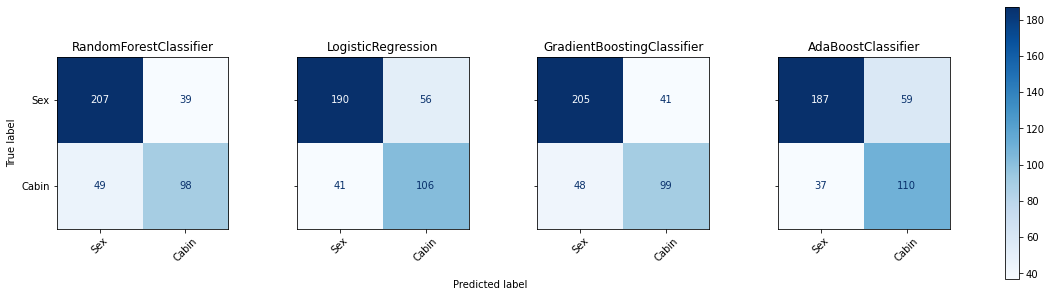

In [26]:
plot_confusion_matrix()

Na podstawie powyzszych macierzy bledow mozemy odczytac jaka czesc probek zostala zaklasyfikowana prawidlowo dla danego klasyfikatora. **Najlepiej spisal sie RandomForests - 305 poprawnych na 393 probki, najgorzej LogisticRegression - 296 poprawnych.** Najwiecej falszywie pozytywnych (prawy gorny rog) mamy dla AdaBoostClassifier, natomiast najwiecej falszywie negatywnych (lewy dolny rog) ukazuje sie dla RandomForest. Ogolnie mozemy powiedziec, ze algorytmy spisaly sie dosc podobnie - miedzy "najlepszym" a "najgorszym" mamy roznice na poziomie 8 klasyfikacji.

<h2> 6.2 Tablice pomylek dla danych o niskiej liczebnosci cech dla zbiorow testowych. </h2>

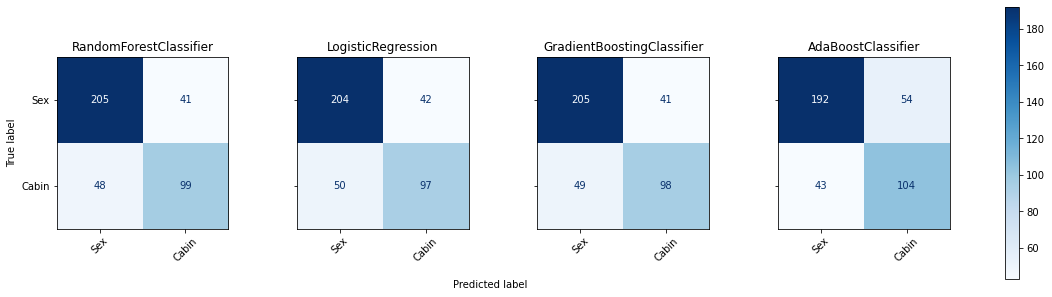

In [27]:
plot_confusion_matrix(confusion_matrix_list = confusion_matrix_list_low)

Dla danych o niskiej liczebnosci cech klasyfikatory **RandomForests, LogisticRegression i GradientBoost** poradzily sobie **bardzo podobnie** - wyniki poprawnej klasyfikacji probek odpowiednio 304, 301 i 303. Nieco slabiej wypadl AdaBoost z wynikiem rownym 296, natomiast nie wydaje sie byc to duza roznica - ok 2% probek wiecej zle sklasyfkiowanych od najlepiej tutaj wypadajacego RandomForesta.

<h2> 6.3 Krotkie podsumowanie. </h2>

Dla wszystkich klasyfikatorow mozemy zauwazyc podobne wyniki oraz podobne zachowanie - w kazdym wystapilo zjawisku overfittingu dla danych o wysokiej liczebnosci cech. Dla danych o niskiej liczebnosci cech wszystkie algorytmy zwrocily podobne wyniki, zblizone miedzy zbiorami treningowymi oraz testowymi i nizsze od tych wyliczonych dla danych o wysokiej kardynalnosci. **Najwieksza tendencje do nadmiernego dopasowania obserwujemy dla GradientBoostingClassifier oraz RandomForests.**
Wedlug mnie **najlepiej sposrod badanych klasyfikatoro poradzila sobie regresja logistyczna - jest ona rowniez najprostsza w zrozumieniu dzialania.**

<h1> 7. Predict() vs predict_proba() </h1>

<li> <b> predict() </b> - przewiduje rzeczywista klase, zwraca liczbe np. 0, 1 </li>
<li> <b> predict_proba() </b> - przewiduje prawodopodobienstwo przypisania klasy do danego obiektu np. 0.3, 0.6 </li>